# Problem Statement


Any natural language is a medium of communication used by human beings. Natural languages are quite difficult to process using algorithms considering its complexity and variants. Natural Language Processing (NLP) mainly includes three tasks,

- Lexical Processing: Statistical analysis of words present in the given corpora and gain inferences out of it. This can be used for document classification, spam/non-spam classification etc. 

- Syntactic Processing: This includes parsing of sentences and their grammatical structure without considering its meaning. It includes Parts Of Speech (POS) tagging, Information Extraction etc.

- Semantic Processing: This final part includes gaining the meaningful insights out of given corpora. It can be used for higher level application like building program to chat with users to assist them (e.g. customer service).

Here, we are going to focus on POS tagging part of NLP using Viterbi algorithm and regular expression.

POS Tagging: POS (Parts Of Speech) tagging includes tagging English POS (in this case) to each word in the given corpora. The purpose of POS tagging in NLP is to understand correctness of grammatical integrity and extract relationship between each word.

Viterbi Algorithm: It is based on an assumption that POS tag for current words depends upon POS tag for previous word and current word itself (Hidden Markov Model - HMM). It does steps by step maximization of ***P(word_n|POS_n) * P(POS_n|POS_n-1)***. 

For more insights on Viterbi algorithm please check this link:
https://www.freecodecamp.org/news/a-deep-dive-into-part-of-speech-tagging-using-viterbi-algorithm-17c8de32e8bc/

### Dependancies

In [1]:
# Importing libraries

import nltk
nltk.download('treebank')
from nltk.probability import FreqDist

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time
import random
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/kishanakbari/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


## 1. Reading Dataset

NLTK (Natural Language Took-Kit) is having many corpora (datasets). Here, we would be using **treebank corpus** for our algorithm. Here, we would be using universal tag-set as it contains only 12 tags which are easier to parse and computationally less expensive.

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
len(nltk_data)

3914

There are 3914 sentenses in the treebank dataset.

In [4]:
nltk_data[0:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

Dataset is in the form of list of sentences where each sentence is a list of tuples. Each tuple contains a word and corresponding POS tag.

Dataset format:
data = [[sent_1], [sent_2], [sent_3],....[sent_n]]

where,
sent_n = [(word_1, POS_1), (word_2, POS_2),....(word_n, POS_n)]

## 2. Train-Test Split

In [5]:
# Splitting into train and test

random.seed(42)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

print('Train set size:', len(train_set))

print(' ')

print('Test set size:', len(test_set))

Train set size: 3718
 
Test set size: 196


We would be using only 5% of the data as test set because Viterbi is a computationally expensive algorithm.

## 3. EDA

In [6]:
# train tagged words

train_tagged_words = [x for y in train_set for x in y]
len(train_tagged_words)

95725

Train set is having total 95558 tagged words. It can be repeating as well in line to corpus. Same words can be having different POS tags based on its applicability in the sentence.

In [7]:
# train_words: words in train set

train_words = [x[0] for x in train_tagged_words]
print(train_words[:50])

['But', 'in', 'one', 'of', 'the', 'auctions', 'in', 'question', ',', 'International', 'Business', 'Machines', 'Corp.', 'made', 'a', 'bid', 'substantially', 'higher', 'than', 'the', 'Fujitsu', 'offer', ',', 'according', 'to', 'the', 'municipality', '.', 'Both', 'Moody', "'s", 'and', 'S&P', 'cited', 'First', 'Boston', "'s", 'reliance', 'in', 'recent', 'years', 'on', 'merchant', 'banking', ',', 'which', '*T*-1', 'has', 'been', 'responsible']


In [8]:
# train set vocabulary

train_vocab = set(train_words)
print(len(train_vocab))

12093


Total vocabulary size for train set is 12076.

In [9]:
# tags from train set
tags = set([x[1] for x in train_tagged_words])

print(tags)

print(' ')

print(len(tags))

{'.', 'PRON', 'ADV', 'NOUN', 'ADJ', 'NUM', 'DET', 'CONJ', 'VERB', 'PRT', 'X', 'ADP'}
 
12


Total 12 unique POS tags as per universal tagger standards.

### Developing Tagger as per Viterbi Algorithm

Bayes Theorem:

**P(POS|word) = P(word|POS)P(POS)/P(word)**

Emission Probability = P(word|POS)

Transition Probability = P(POS_n|POS_n-1) 

Where, 

`P(POS|word)` is conditional probability of the tag for a given word,

`p(word|POS)` is the emission probability or conditional probability of the word for given tag,

`p(POS_n|POS_n-1)` is the transition probability or conditional probability of the POS tag for the given previous POS tag.

In [10]:
# Emission Probability
# Here, 'tag' stands for POS tag

def emission(word, tag, train = train_tagged_words):
    tag_list = [x for x in train if x[1]==tag]
    w_given_tag_list = [x[0] for x in tag_list if x[0]==word]
    count_tag = len(tag_list)
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag/count_tag)

In [11]:
# Transition Probability

def transition(t2, t1, train = train_tagged_words):
    tags = [x[1] for x in train]
    count_t1 = len([x for x in tags if x==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1/count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = transition(t2, t1)

In [13]:
# convert the matrix to a df for better readability

tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,.,PRON,ADV,NOUN,ADJ,NUM,DET,CONJ,VERB,PRT,X,ADP
.,0.093317,0.065934,0.052873,0.221131,0.043596,0.079625,0.174293,0.059359,0.089894,0.002432,0.027382,0.090074
PRON,0.039908,0.008058,0.031850,0.211051,0.074444,0.007675,0.008058,0.005372,0.485035,0.013047,0.092863,0.022640
ADV,0.137645,0.014925,0.079602,0.031841,0.130017,0.030846,0.068325,0.006965,0.342620,0.014262,0.023217,0.119735
NOUN,0.239840,0.004839,0.017282,0.264508,0.012225,0.009460,0.013280,0.042350,0.146771,0.043769,0.028925,0.176751
ADJ,0.064277,0.000658,0.004439,0.699984,0.067401,0.020549,0.004767,0.016932,0.012329,0.011014,0.020878,0.076771
NUM,0.116175,0.001489,0.002979,0.355973,0.033065,0.184987,0.002979,0.013405,0.017873,0.027703,0.207626,0.035746
DET,0.017252,0.003619,0.012788,0.639884,0.203523,0.021957,0.005550,0.000483,0.039932,0.000241,0.045120,0.009651
CONJ,0.036111,0.056944,0.055093,0.346759,0.117593,0.040741,0.120833,0.000463,0.157870,0.004630,0.008796,0.054167
VERB,0.033930,0.036099,0.081339,0.110775,0.065458,0.023085,0.133550,0.005345,0.168487,0.031606,0.218297,0.092029
PRT,0.041844,0.017980,0.010461,0.247793,0.085649,0.057862,0.101667,0.002288,0.399150,0.001635,0.013076,0.020595


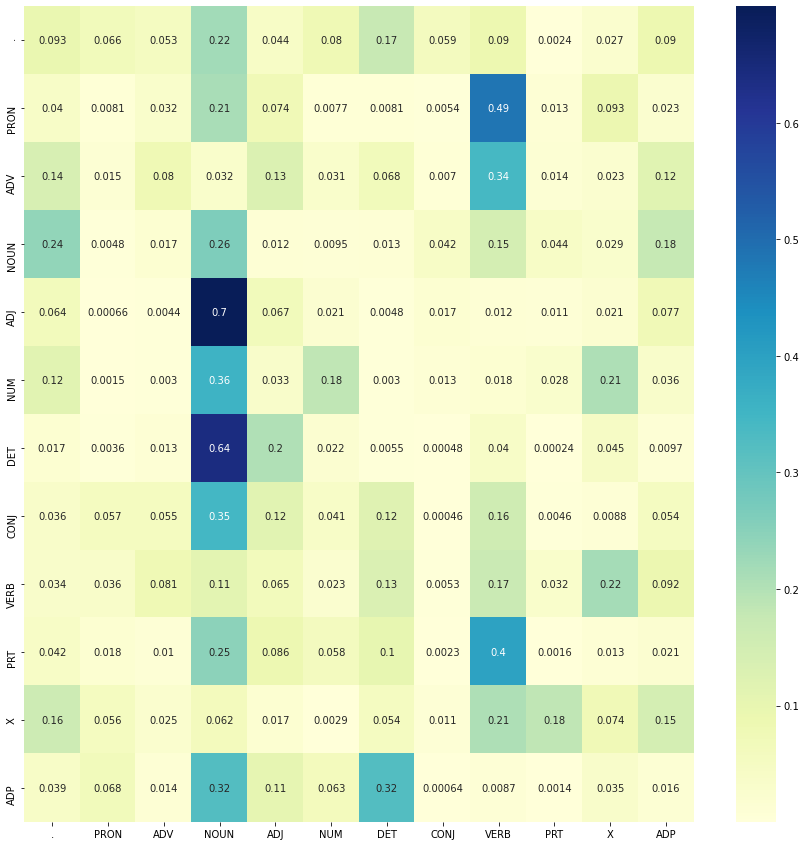

In [14]:
# transition map

plt.figure(figsize=(15, 15))
sns.heatmap(tags_df, cmap='YlGnBu', annot=True)
plt.show()

Observation,
- DET followed by NOUN is having probability of 0.64.
- ADJ followed by NOUN is having probability of 0.7.
- PRON followed by VERB is having probability of 0.49.

In [15]:
# Developing Viterbi algorithm funcation: Returns words and corresponding predicted POS tag


def Viter1(words, train_bag = train_tagged_words):
    count1 = 0
    state = []
    
    for key, word in enumerate(words):
        p = [] 
        for tag in tags:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            emission_p = emission(word, tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
                       
        pmax = max(p)
        T = list(tags)
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        # print(count1, word, state_max)
        count1 += 1
    return list(zip(words, state))

In [16]:
start = time.time()
test_pred = Viter1([x[0] for y in test_set for x in y])
end = time.time()
difference = end-start
print("Time taken (in seconds): ", difference)

Time taken (in seconds):  622.1105971336365


In [17]:
# accuracy check
# wrong_pos --> there are words which are wrongly tagged by our tagger

test_tagged_words = [x for y in test_set for x in y]
wrong_pos = [(i,j,k) for i,j,k in list(zip([x[0] for x in test_tagged_words],
                                  [x[1] for x in test_tagged_words],
                                  [x[1] for x in test_pred])) if j != k]
accuracy1 = 1-len(wrong_pos)/len(test_tagged_words)
accuracy1

0.9048677034942436

We are getting accuracy of ~90% on the test set, which is good. But let's try to improve it further.

#### Checking unknown words

- Words which are not present in train set but are there in test set. These words would be having emission probability of 0.
- We would be using `Regular Expression` based tagger for unknown words instead of using Viterbi method

`Regular Expression` based Tagger: We use a set of rules to define the POS for the given word. Rules can be related to alphabets in word itself. e.g. words ending with 'ing' should be tagged as VERB. 

In [18]:
unknown_words_pos = [x for x in wrong_pos if x[0] not in train_vocab]
unknown_words_pos[0:10]

[('beds', 'NOUN', '.'),
 ('Bowery', 'NOUN', '.'),
 ('Mission', 'NOUN', '.'),
 ('drearier', 'ADV', '.'),
 ('tuck', 'VERB', '.'),
 ('Garret', 'NOUN', '.'),
 ('teaches', 'VERB', '.'),
 ('Earlham', 'NOUN', '.'),
 ('structure', 'NOUN', '.'),
 ('ugly', 'ADJ', '.')]

This is a subset of wrongly tagged words which are not present in training set.

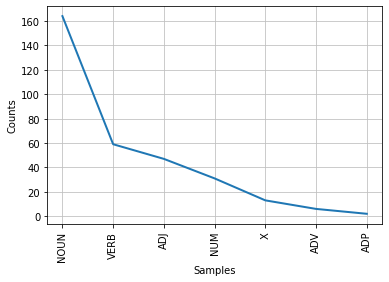

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
# Checking distribution of unknown words POs tags

FreqDist([x[1] for x in unknown_words_pos]).plot()

Observation,
- Tagger unable to tag `NOUN`, `VERB`, `ADJ`, `NUM`, `X` and `ADV` from unknown group of words. It is assigning all above kind to `ADP` because `ADP` is the first tag in out transition probability matrix. 


Next, lets do analysis of words from unknown group and try to develop a set of rules to tag them correctly.

#### VERB analysis

In [20]:
print([x for x in unknown_words_pos if x[1] =='VERB'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='VERB']))

[('tuck', 'VERB', '.'), ('teaches', 'VERB', '.'), ('dominating', 'VERB', '.'), ('trail', 'VERB', '.'), ('lessening', 'VERB', '.'), ('sabotage', 'VERB', '.'), ('reimbursed', 'VERB', '.'), ('impede', 'VERB', '.'), ('APPEARS', 'VERB', '.'), ('slated', 'VERB', '.'), ('sliding', 'VERB', '.'), ('zoomed', 'VERB', '.'), ('enclosed', 'VERB', '.'), ('transporting', 'VERB', '.'), ('queuing', 'VERB', '.'), ('helps', 'VERB', '.'), ('delisted', 'VERB', '.'), ('TRIMMING', 'VERB', '.'), ('soliciting', 'VERB', '.'), ('pulled', 'VERB', '.'), ('agreeing', 'VERB', '.'), ('frightened', 'VERB', '.'), ('Getting', 'VERB', '.'), ('encourages', 'VERB', '.'), ('broaden', 'VERB', '.'), ('floated', 'VERB', '.'), ('ratcheting', 'VERB', '.'), ('urge', 'VERB', '.'), ('stresses', 'VERB', '.'), ('clashed', 'VERB', '.'), ('tanked', 'VERB', '.'), ('laid', 'VERB', '.'), ('wrecking', 'VERB', '.'), ('investigate', 'VERB', '.'), ('burn', 'VERB', '.'), ('transforming', 'VERB', '.'), ('acquires', 'VERB', '.'), ('generated', 'V

In [21]:
print([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ing')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ing')]))

['dominating', 'lessening', 'sliding', 'transporting', 'queuing', 'soliciting', 'agreeing', 'Getting', 'ratcheting', 'wrecking', 'transforming', 'clearing', 'photocopying', 'Performing', 'wrestling', 'appealing', 'appealing', 'broadcasting', 'rallying']
 
19


In [22]:
print([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ed')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('ed')]))

['reimbursed', 'slated', 'zoomed', 'enclosed', 'delisted', 'pulled', 'frightened', 'floated', 'clashed', 'tanked', 'generated', 'noticed', 'lengthened', 'exhausted', 'justified', 'depended']
 
16


In [23]:
print([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('es')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='VERB' and x[0].endswith('es')]))

['teaches', 'encourages', 'stresses', 'acquires', 'approves']
 
5


We can see many words which are ending with 'ing' or 'ed' or 'es' which are actually verbs but tagged as 'ADP'. Hence we would defined rules for that.

In [24]:
patterns_verb = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
]

#### ADV analysis

In [25]:
print([x for x in unknown_words_pos if x[1] =='ADV'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='ADV']))

[('drearier', 'ADV', '.'), ('twice', 'ADV', '.'), ('implicitly', 'ADV', '.'), ('apart', 'ADV', '.'), ('scarcely', 'ADV', '.'), ('rhythmically', 'ADV', '.')]
 
6


In [26]:
print([x[0] for x in unknown_words_pos if x[1] =='ADV' and x[0].endswith('ly')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='ADV' and x[0].endswith('ly')]))

['implicitly', 'scarcely', 'rhythmically']
 
3


We can see many words which are ending with 'ly' which are actually 'ADV' but tagged as 'ADP'. Hence we would defined rule for that.

In [27]:
patterns_adv = [
    (r'.*ly$', 'ADV')
]

#### X Analysis

In [28]:
print([x for x in unknown_words_pos if x[1] =='X'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='X']))

[('*-119', 'X', '.'), ('*-118', 'X', '.'), ('*T*-192', 'X', '.'), ('*T*-206', 'X', '.'), ('*-102', 'X', '.'), ('*-102', 'X', '.'), ('*T*-89', 'X', '.'), ('*-152', 'X', '.'), ('*T*-165', 'X', '.'), ('*T*-50', 'X', '.'), ('*T*-220', 'X', '.'), ('*T*-50', 'X', '.'), ('*-166', 'X', '.')]
 
13


These are the foreign words which should be tagged as 'X' but are predicted as 'ADP'. We can't define as any rule for such words. Hence, we would leave them as it is.

#### NOUN Analysis

In [29]:
print([x for x in unknown_words_pos if x[1] =='NOUN'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='NOUN']))

[('beds', 'NOUN', '.'), ('Bowery', 'NOUN', '.'), ('Mission', 'NOUN', '.'), ('Garret', 'NOUN', '.'), ('Earlham', 'NOUN', '.'), ('structure', 'NOUN', '.'), ('brat', 'NOUN', '.'), ('pack', 'NOUN', '.'), ('best-seller', 'NOUN', '.'), ('charts', 'NOUN', '.'), ('heavy-truck', 'NOUN', '.'), ('passenger-car', 'NOUN', '.'), ('AIDS', 'NOUN', '.'), ('sky', 'NOUN', '.'), ('likelihood', 'NOUN', '.'), ('Guerrilla', 'NOUN', '.'), ('Namibia', 'NOUN', '.'), ('printing-press', 'NOUN', '.'), ('India', 'NOUN', '.'), ('Experts', 'NOUN', '.'), ('Kathryn', 'NOUN', '.'), ('McAuley', 'NOUN', '.'), ('reserve', 'NOUN', '.'), ('brakes', 'NOUN', '.'), ('Ark', 'NOUN', '.'), ('skill', 'NOUN', '.'), ('stigma', 'NOUN', '.'), ('campaigner', 'NOUN', '.'), ('Rozell', 'NOUN', '.'), ('mininum-wage', 'NOUN', '.'), ('employers', 'NOUN', '.'), ('elimination', 'NOUN', '.'), ('Silicon', 'NOUN', '.'), ('trading-company', 'NOUN', '.'), ('Stockbrokers', 'NOUN', '.'), ('departures', 'NOUN', '.'), ('Ensrud', 'NOUN', '.'), ('GROWTH',

In [30]:
print([x[0] for x in unknown_words_pos if x[1] =='NOUN' and x[0].endswith('s')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='NOUN' and x[0].endswith('s')]))

['beds', 'charts', 'printing-press', 'Experts', 'brakes', 'employers', 'Stockbrokers', 'departures', 'Jerritts', 'autos', 'lobbies', 'burdens', 'doors', 'desires', 'awareness', 'incentives', 'Jerritts', 'fuels', 'milestones', 'kilobytes', 'acquirers', 'Ellis', 'conferees', 'floors', 'tapes', 'Monopolies', 'Mergers', 'tires', 'arbs', 'rivals', 'Works', 'dummies', 'impetus', 'Chivas', 'phobias', 'depressions', 'variables', 'Reasons', 'Institutions', 'Palisades', 'beers']
 
41


We can see many words which are ending with 's' which are actually 'NOUN' but tagged as 'ADP'. Hence we would defined rule for that.

In [31]:
patterns_noun = [
        (r'.*s$', 'NOUN'),              # plural nouns
]

#### ADJ Analysis

In [32]:
print([x for x in unknown_words_pos if x[1] =='ADJ'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='ADJ']))

[('ugly', 'ADJ', '.'), ('youthful', 'ADJ', '.'), ('dismal', 'ADJ', '.'), ('benevolent', 'ADJ', '.'), ('altruistic', 'ADJ', '.'), ('tired', 'ADJ', '.'), ('Abrupt', 'ADJ', '.'), ('unheard', 'ADJ', '.'), ('free-lance', 'ADJ', '.'), ('ECONOMIC', 'ADJ', '.'), ('2,050-passenger', 'ADJ', '.'), ('prior-year', 'ADJ', '.'), ('high-quality', 'ADJ', '.'), ('priciest', 'ADJ', '.'), ('unsympathetic', 'ADJ', '.'), ('TIRED', 'ADJ', '.'), ('intentioned', 'ADJ', '.'), ('cleaner-burning', 'ADJ', '.'), ('Texas-based', 'ADJ', '.'), ('40-megabyte', 'ADJ', '.'), ('when-issued', 'ADJ', '.'), ('longest', 'ADJ', '.'), ('sprawling', 'ADJ', '.'), ('balkanized', 'ADJ', '.'), ('mammoth', 'ADJ', '.'), ('87-store', 'ADJ', '.'), ('food-shop', 'ADJ', '.'), ('low-cost', 'ADJ', '.'), ('muzzling', 'ADJ', '.'), ('overleveraged', 'ADJ', '.'), ('intelligent', 'ADJ', '.'), ('insane', 'ADJ', '.'), ('gradual', 'ADJ', '.'), ('Egyptian', 'ADJ', '.'), ('Lead', 'ADJ', '.'), ('student-test', 'ADJ', '.'), ('inevitable', 'ADJ', '.'), 

In [33]:
print([x[0] for x in unknown_words_pos if x[1] =='ADJ' and x[0].endswith('est')])

print(' ')

print(len([x[0] for x in unknown_words_pos if x[1] =='ADJ' and x[0].endswith('est')]))

['priciest', 'longest', 'student-test']
 
3


There are a few words ending with 'est' should be considered as 'ADJ'. These words are very less in count. Hence, we would not try to assign any rule. This is to avoid any sort of over-fitting and try to define as generic rules as possible.

#### NUM Analysis

In [34]:
print([x for x in unknown_words_pos if x[1] =='NUM'])

print(' ')

print(len([x for x in unknown_words_pos if x[1] =='NUM']))

[('169.9', 'NUM', '.'), ('1933', 'NUM', '.'), ('1961', 'NUM', '.'), ('1968', 'NUM', '.'), ('185.9', 'NUM', '.'), ('737.5', 'NUM', '.'), ('3.01', 'NUM', '.'), ('23.25', 'NUM', '.'), ('20.07', 'NUM', '.'), ('87.5', 'NUM', '.'), ('38.875', 'NUM', '.'), ('210', 'NUM', '.'), ('512', 'NUM', '.'), ('374.20', 'NUM', '.'), ('2,099', 'NUM', '.'), ('49.9', 'NUM', '.'), ('47.1', 'NUM', '.'), ('339', 'NUM', '.'), ('2.15', 'NUM', '.'), ("'40s", 'NUM', '.'), ("'50s", 'NUM', '.'), ('71,309', 'NUM', '.'), ('550,000', 'NUM', '.'), ('1.56', 'NUM', '.'), ('372.14', 'NUM', '.'), ('191.9', 'NUM', '.'), ('1614', 'NUM', '.'), ('5.1', 'NUM', '.'), ('29.3', 'NUM', '.'), ('28.4', 'NUM', '.'), ('29.9', 'NUM', '.')]
 
31


In [35]:
patterns_numbers = [
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
]

#### Final pattern for Regex

We need to assign some POS for the words which aren't aligned to any rule. Since we know that most of the words which are unknown belong to `NOUN` category, we would be using that as default tag.

In [36]:
# Final pattern

pattern = [
    (r'.*ing$', 'VERB'),            # gerund
    (r'.*ed$', 'VERB'),             # past tense
    (r'.*es$', 'VERB'),             # 3rd singular present
    (r'.*ly$', 'ADV'),              # gerund
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*s$', 'NOUN'),              # plural nouns
    (r'.*', 'NOUN')                 # nouns
]

In [37]:
# Defining Regex based tagger

regexp_tagger = nltk.RegexpTagger(pattern)

In [38]:
# Viterbi  and Regex tagger: Viterbi with added condition for unknown words


def Viter2(words, train_bag = train_tagged_words):
    count1 = 0
    state = []
    T = list(tags)
    
    for key, word in enumerate(words):
        if word in train_vocab: 
            p = [] 
            for tag in tags:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                emission_p = emission(word, tag)
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            state_max = T[p.index(pmax)]
        
        else:
            # print('unknown trigger!')
            state_max = regexp_tagger.tag([word])[0][1]
        
        state.append(state_max)
        # print(count1, word, state_max)
        count1 += 1
    return list(zip(words, state))

In [39]:
start = time.time()
test_pred2 = Viter2([x[0] for y in test_set for x in y])
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  546.0527780056


In [40]:
# accuracy

wrong_pos2 = [(i,j,k) for i,j,k in list(zip([x[0] for x in test_tagged_words],
                                  [x[1] for x in test_tagged_words],
                                  [x[1] for x in test_pred2])) if j != k]
accuracy2 = 1-len(wrong_pos2)/len(test_tagged_words)
accuracy2

0.9503130680670572

We can observe some improvement in the accuracy a compared to only Viterbi based model.

In [41]:
unknown_words_pos2 = [x for x in wrong_pos2 if x[0] not in train_vocab]
print(unknown_words_pos2)

print(' ')

print(len(unknown_words_pos2))

[('drearier', 'ADV', 'NOUN'), ('tuck', 'VERB', 'NOUN'), ('ugly', 'ADJ', 'ADV'), ('youthful', 'ADJ', 'NOUN'), ('trail', 'VERB', 'NOUN'), ('sabotage', 'VERB', 'NOUN'), ('twice', 'ADV', 'NOUN'), ('brakes', 'NOUN', 'VERB'), ('impede', 'VERB', 'NOUN'), ('dismal', 'ADJ', 'NOUN'), ('benevolent', 'ADJ', 'NOUN'), ('altruistic', 'ADJ', 'NOUN'), ('tired', 'ADJ', 'VERB'), ('*-119', 'X', 'NOUN'), ('Abrupt', 'ADJ', 'NOUN'), ('departures', 'NOUN', 'VERB'), ('unheard', 'ADJ', 'NOUN'), ('free-lance', 'ADJ', 'NOUN'), ('ECONOMIC', 'ADJ', 'NOUN'), ('APPEARS', 'VERB', 'NOUN'), ('2,050-passenger', 'ADJ', 'NOUN'), ('prior-year', 'ADJ', 'NOUN'), ('high-quality', 'ADJ', 'NOUN'), ('priciest', 'ADJ', 'NOUN'), ('unsympathetic', 'ADJ', 'NOUN'), ('helps', 'VERB', 'NOUN'), ('lobbies', 'NOUN', 'VERB'), ('TIRED', 'ADJ', 'NOUN'), ('TRIMMING', 'VERB', 'NOUN'), ('*-118', 'X', 'NOUN'), ('*T*-192', 'X', 'NOUN'), ('*T*-206', 'X', 'NOUN'), ('broaden', 'VERB', 'NOUN'), ('billing', 'NOUN', 'VERB'), ('urge', 'VERB', 'NOUN'), ('

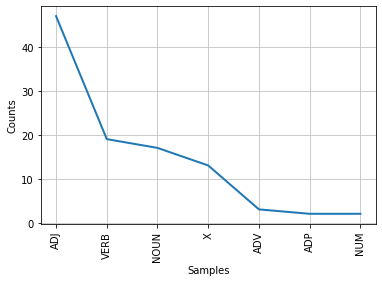

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [42]:
# Checking distribution of unknown words POS tags

FreqDist([x[1] for x in unknown_words_pos2]).plot()

In [43]:
print([x for x in unknown_words_pos2 if x[1] =='ADJ'])

print(' ')

print(len([x for x in unknown_words_pos2 if x[1] =='ADJ']))

[('ugly', 'ADJ', 'ADV'), ('youthful', 'ADJ', 'NOUN'), ('dismal', 'ADJ', 'NOUN'), ('benevolent', 'ADJ', 'NOUN'), ('altruistic', 'ADJ', 'NOUN'), ('tired', 'ADJ', 'VERB'), ('Abrupt', 'ADJ', 'NOUN'), ('unheard', 'ADJ', 'NOUN'), ('free-lance', 'ADJ', 'NOUN'), ('ECONOMIC', 'ADJ', 'NOUN'), ('2,050-passenger', 'ADJ', 'NOUN'), ('prior-year', 'ADJ', 'NOUN'), ('high-quality', 'ADJ', 'NOUN'), ('priciest', 'ADJ', 'NOUN'), ('unsympathetic', 'ADJ', 'NOUN'), ('TIRED', 'ADJ', 'NOUN'), ('intentioned', 'ADJ', 'VERB'), ('cleaner-burning', 'ADJ', 'VERB'), ('Texas-based', 'ADJ', 'VERB'), ('40-megabyte', 'ADJ', 'NOUN'), ('when-issued', 'ADJ', 'VERB'), ('longest', 'ADJ', 'NOUN'), ('sprawling', 'ADJ', 'VERB'), ('balkanized', 'ADJ', 'VERB'), ('mammoth', 'ADJ', 'NOUN'), ('87-store', 'ADJ', 'NOUN'), ('food-shop', 'ADJ', 'NOUN'), ('low-cost', 'ADJ', 'NOUN'), ('muzzling', 'ADJ', 'VERB'), ('overleveraged', 'ADJ', 'VERB'), ('intelligent', 'ADJ', 'NOUN'), ('insane', 'ADJ', 'NOUN'), ('gradual', 'ADJ', 'NOUN'), ('Egypti

Here, we don't see any further possible rules for 'ADJ' words. Hence, we would finalize `Viter2` as model for POS tagging.

#### Testing on new sentences

In [44]:
# input sentence

sent = 'Hurray!!! This is summer time. Let us have fun!'

In [45]:
# Dependancy

from nltk import word_tokenize

In [46]:
# tokenize sentence

sent_tokens = word_tokenize(sent)
sent_tokens

['Hurray',
 '!',
 '!',
 '!',
 'This',
 'is',
 'summer',
 'time',
 '.',
 'Let',
 'us',
 'have',
 'fun',
 '!']

In [47]:
Viter2(sent_tokens)

[('Hurray', 'NOUN'),
 ('!', '.'),
 ('!', '.'),
 ('!', '.'),
 ('This', 'DET'),
 ('is', 'VERB'),
 ('summer', 'NOUN'),
 ('time', 'NOUN'),
 ('.', '.'),
 ('Let', 'NOUN'),
 ('us', 'PRON'),
 ('have', 'VERB'),
 ('fun', 'NOUN'),
 ('!', '.')]

## Conclusion

- Viterbi is a powerful algorithm for POS tagging. It is time consuming but gives accurate results.
- Viterbi can be further improved using algorithms like Regex tagger.

---------------------